## Processing, vizualization, and statistical analysis of metatranscriptome data

In [4]:
import pandas as pd
#pip install -U numpy==1.26.4
import numpy as np
import seaborn as sns
import glob
import matplotlib.pyplot as plt
import matplotlib
import pypalettes
from pypalettes import load_cmap
from pypalettes import get_hex
from matplotlib.patches import Patch
from Bio import SeqIO
from scipy import stats
from scipy.stats import zscore
from scipy.stats import tukey_hsd
from matplotlib.patches import Patch
from matplotlib.patches import Circle
import matplotlib.lines as mlines
from ete3 import NCBITaxa

In [5]:
#Load info to convert ncbi accessions to taxonomy
ncbi = NCBITaxa()

In [6]:
#Standardize figure aesthetics and save dictionary of sample types
sns.set_theme(context = 'paper',style='whitegrid',font_scale=2)
sample_dict = {'SS0122_S12':'Picked colonies','SS0123_S13':'Picked colonies','SS0125_S15':'Picked colonies','SS0126_S16':'Picked colonies',
               'SS0124_S14':'Slick','SS0127_S17':'Slick'}

## Differential expression of phage genes on picked colonies vs. in slick

In [4]:
##Read in BWA mapping to virus genome
slick_annotations = pd.read_csv('annotation_files/unified_annotations_slick.csv').dropna(how='all',axis=1)
slick_bed = slick_annotations[['cds_id','start','end']]
slick_bed.loc[:,'start'] = slick_annotations[['start','end']].min(axis=1)
slick_bed.loc[:,'end'] = slick_annotations[['start','end']].max(axis=1)
to_cat = []
#For each sample, read in coverage file resulting from BWA mapping to T.NPSG.2 genome (slick phage)
for file in glob.glob('metaT_files/*_phage_metaT_coverage.tab'):
    temp_bed = slick_bed.copy()
    sample_id = file.rsplit('/',maxsplit=1)[1].split('_')[0]+'_'+file.rsplit('/',maxsplit=1)[1].split('_')[1]
    #read in bwa mapping to metatranscriptome assembly to calculate sum of all RPKs
    all_cov = pd.read_csv('metaT_files/'+sample_id+'_L006_metaT_coverage.tab',sep='\t')
    pm_scale = (all_cov['numreads']/(all_cov['endpos']/1000)).sum()/1000000
    #read in bwa mapping to phage genome
    infile = pd.read_csv(file,sep='\t',header=None,names=['genome','start','end','depth','reads']).drop(['genome'],axis=1).set_index('end')
    temp_bed.loc[:,'depth'] = temp_bed['end'].map(infile['depth'])
    temp_bed.loc[:,'reads'] = temp_bed['end'].map(infile['reads'])
    temp_bed.loc[:,'length'] = temp_bed['end'] - temp_bed['start']
    #rpk = reads mapped per kilobase of CDS, add .5 to all so no zeros in final dataset
    temp_bed.loc[:,'rpk'] = (temp_bed['reads']+.5)/(temp_bed['length']/1000)
    temp_bed.loc[:,'tpm'] = (temp_bed['rpk']/pm_scale)
    temp_bed = temp_bed.set_index('cds_id')
    tpms = temp_bed['tpm']
    tpms.name = sample_id
    to_cat.append(tpms)

phage_tpm = pd.concat(to_cat,axis=1)
#phage_tpm.to_csv('metaT_files/phage_tpm.csv')

In [5]:
#Set color palette for phage gene TPM by functional group - same as Figure 1a
hex_colors = load_cmap("golduck").hex
function_palette = {'tail':hex_colors[5], 'head and packaging':hex_colors[8],
                    'DNA, RNA and nucleotide metabolism':hex_colors[0],'integration and excision':hex_colors[1],'transcription regulation':hex_colors[2],'RM system':hex_colors[3], 'Phage defense':'#d0eafb',
                   'auxiliary metabolism, host takeover':hex_colors[9],'Host range determination':hex_colors[12],'lysis':hex_colors[11],
                    'unknown function':'#cccccc', 'conserved protein of unknown function':'#000000'}

In [6]:
slick_annotations = slick_annotations.set_index('cds_id')
slick_annotations.loc[:,'color'] = slick_annotations['function'].map(function_palette)
tpm_stacked = phage_tpm.stack().reset_index()
tpm_stacked.columns = ['cds_id','sample','tpm']
tpm_stacked.loc[:,'log_tpm'] = np.log10(tpm_stacked['tpm'])
tpm_stacked.loc[:,'source'] = tpm_stacked['sample'].map(sample_dict)
tpm_stacked.loc[:,'function'] = tpm_stacked['cds_id'].map(slick_annotations['function'])

/jet/home/agomez3/.local/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 16.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/jet/home/agomez3/.local/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 9.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/jet/home/agomez3/.local/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 16.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/jet/home/agomez3/.local/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 9.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/jet/home/agomez3/.local/lib/python3.12/site-packages/seaborn/

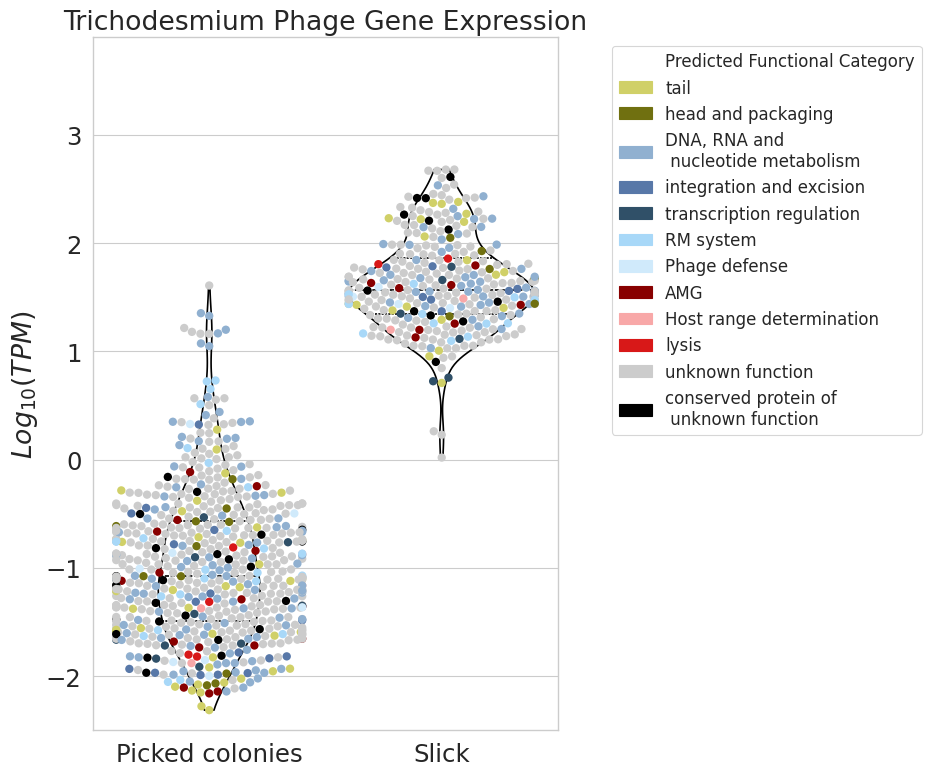

In [7]:
fig, ax = plt.subplots(figsize=(6,9))
g = sns.swarmplot(data=tpm_stacked,x='source',y='log_tpm',hue='function',palette=function_palette,ax=ax,legend=False,s=6)
j = sns.violinplot(data=tpm_stacked,x='source',y='log_tpm',ax=ax,cut=0,fill=False,inner="quart",color='black')
handles1 = []
handles1.append(Patch(color='#FFFFFF00',label='Predicted Functional Category'))
for i in function_palette.keys():
    if i == 'conserved protein of unknown function':
        handles1.append(Patch(color=function_palette[i],label='conserved protein of \n unknown function'))
    elif i == 'DNA, RNA and nucleotide metabolism':
        handles1.append(Patch(color=function_palette[i],label='DNA, RNA and \n nucleotide metabolism'))
    elif i == 'auxiliary metabolism, host takeover':
        handles1.append(Patch(color=function_palette[i],label='AMG'))
    else:
        handles1.append(Patch(color=function_palette[i],label=i))
first_legend = ax.legend(handles=handles1, bbox_to_anchor=(1.8,1), loc="upper right",fontsize=12)
ax.set_ylim(-2.5,3.9)
g.set_ylabel('$Log_{10}(TPM)$')
g.set_xlabel('')
g.set_title('Trichodesmium Phage Gene Expression')
#plt.savefig('output_figures/fig2a_phage_metaT_swarm.svg',transparent=True,bbox_inches='tight')

In [8]:
#Kolmogorov-Smirnov test phage gene expression on picked colones vs. slick
non_slick = tpm_stacked[tpm_stacked['source'] == 'Picked colonies']['tpm']
slick = tpm_stacked[tpm_stacked['source'] == 'Slick']['tpm']
stats.kstest(slick, non_slick)

KstestResult(statistic=0.970679012345679, pvalue=4.997378844259627e-236, statistic_location=4.501512358047068, statistic_sign=-1)

In [10]:
#phage_tpm.to_csv('output_tables/ST7_phage_tpm.csv')

## Bacterial community transcriptional activity on colonies vs slick

In [7]:
#Read in transcripts per million from salmon quantification of assembled transcripts
all_tpm = pd.read_csv('/ocean/projects/ees240006p/agomez3/tricho_virus/metaT/all_tpm.csv',index_col=0)
contig_tpms = all_tpm.groupby('contig').sum()
#Read in taxonomy estimations from GTDB
gtdb_tax = pd.read_csv('metaT_files/gtdb_taxonomy_result.tsv',sep='\t',header=None,names=['contig','taxid','rank','LCA','1','2','3','4']).drop(['1','2','3','4'],axis=1)
gtdb_tax.loc[:,'length'] = gtdb_tax['contig'].str.split('_',expand=True)[3].astype(int)

In [8]:
#Define function to get lineage names from GTDB last common ancestor (LCA) output
def get_lineage_names(LCA):
    taxid = ncbi.get_name_translator([LCA.strip()])[LCA.strip()][0]
    lineage = ncbi.get_lineage(taxid)
    ranks = ncbi.get_rank(lineage)
    names = ncbi.get_taxid_translator(lineage)
    inverted_dict = {value: names[key] for key, value in ranks.items()}
    all_ranks = ['domain','kingdom','phylum','class','order','family','genus','species']
    i = 0
    previous_rank = 'domain'
    new_dict = {}
    unclassified = False
    while i < 8:
        rank = all_ranks[i]
        if unclassified:
            new_dict[rank] = propogate
        elif rank in inverted_dict.keys():
            new_dict[rank] = inverted_dict[rank]
        else:
            new_dict[rank] = 'unclassified '+ inverted_dict[all_ranks[i-1]]
            propogate = 'unclassified '+ inverted_dict[all_ranks[i-1]]
            unclassified = True
        i += 1
    taxid_series = pd.Series(new_dict)
    return(taxid_series)

In [11]:
#Fix outdated names
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('Trichodesmium sp023356605','Trichodesmium sp.')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('Trichodesmium sp023356535','Trichodesmium sp.')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('Trichodesmium sp023356515','Trichodesmium sp.')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('JAKVCT01 sp022448995','Saprospiraceae bacterium')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('Epibacterium sp004566265','Paracoccaceae bacterium')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('JALEHC01 sp022448955','Saprospiraceae bacterium')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('GCA-2683315 sp036127535','Deltaproteobacteria bacterium')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('Alteromonas sp963922845','Alteromonas')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('Trichodesmium sp010672385','Okeania sp.')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('Okeania sp010692555','Okeania sp.')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('CACIJG01','uncultured Alphaproteobacteria bacterium')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('JANQNR01 sp028279475','Rickettsiales bacterium')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('Trichodesmium sp002260545','Hydrocoleum sp.')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('UBA8653 sp002862275','Phycisphaerales bacterium')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('JASJEE01 sp030064835','Microcoleaceae cyanobacterium MO_207.B10')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('Okeania sp010672585','Okeania sp.')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('Okeania sp014132355','Okeania sp.')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('Okeania sp014132355','Okeania sp.')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('Congregibacter sp039111155','Congregibacter sp.')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('Aureispira sp000724545','Aureispira sp.')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('Trichodesmium sp010672085','Trichodesmium sp.')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('JAAEPI01 sp024232835','Cytophagales bacterium')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('JACMRA01','Minisyncoccota bacterium')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('Henriciella sp038526925','Henriciella sp.')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('TMED54','Alphaproteobacteria bacterium TMED54')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('UBA583 sp022565615','unclassified Archaea')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('Aureispira sp937139495','Aureispira sp.')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('Okeania sp010672455','Okeania sp.')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('GCA-2683315 sp002683315','Deltaproteobacteria bacterium')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('Trichodesmium sp038747755','Trichodesmium sp.')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('UBA8653','Phycisphaerales bacterium')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('UBA7441','Opitutia bacterium')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('Vondammii sp040505915','Vondammii sp.')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('Roseibium sp947494555','Roseibium sp.')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('AAA300-D14 sp002715065','uncultured SAR92 cluster bacterium')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('UBA796','Deltaproteobacteria bacterium ')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('GCA-2862225 sp002862225','Planctomycetaceae bacterium')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('Aureispira sp937942475','Aureispira sp.')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('JAAEPD01 sp024222455','Aureispira sp.')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('JAYYJC01 sp036146655','Myxococcota')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('Okeania sp010672525','Okeania sp.')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('Casp-actino8 sp937902105','Acidimicrobiales')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('UBA11663 sp002863145','Alteromonadaceae bacterium')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('JAKVCP01 sp022448925','Paracoccaceae bacterium')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('JABSOG01','Algicola')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('Okeania sp034190295','Okeania sp.')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('GCA-2708415 sp023301785','Alphaproteobacteria')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('Prochlorococcus A sp003214355','Prochlorococcus sp.')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('Prochlorococcus A','Prochlorococcus sp.')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('Roseibium sp040530035','Roseibium sp.')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('Aureispira sp902727865','Aureispira sp.')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('GCA-2862085 sp002862085','Planctomycetota bacterium')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('JBCBTL01 sp039817845','Cyanobacteriota')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('Sediminibacterium sp012270485','Sediminibacterium sp.')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('JAFKFH01 sp017307375','Alphaproteobacteria bacterium')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('GCA-2707915 sp002707915','Gammaproteobacteria bacterium')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('Prochlorococcus A sp902526435','Prochlorococcus sp.')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('CAJWHX01 sp937911635','uncultured Pseudomonadota bacterium')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('JAKSCJ01 sp022360675','Lysobacterales bacterium')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('GCA-2699365 sp036160955','Coraliomargarita sp.')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('GCA-2699365 sp022448585','Coraliomargarita sp.')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('JAKVBK01 sp022447275','Oceanicola sp.')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('Poseidonia sp002689105','Poseidonia sp.')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('JAYYRS01 sp036126975','Myxococcota bacterium')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('UBA1997','Rickettsiales')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('Maricaulis sp017643585','Maricaulis sp.')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('CALLUQ01 sp938010565','Flavobacteriales bacterium')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('CAWUKV01 sp039817185','uncultured bacterium')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('Cyanobacteriales','Cyanobacteriota')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('UBA8309 sp016780765','Alphaproteobacteria')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('UBA8309 sp016780765','Alphaproteobacteria')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('Pelagibacter sp902595405','Pelagibacter sp.')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('Cyanobacteriia','Cyanobacteriota')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('Trichodesmium sp035285525','Trichodesmium sp.')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('Minisyncoccota bacterium','Bacillati')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('Hydrocoleum sp.','Hydrocoleum')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('Micavibrionaceae','Bdellovibrionaceae')
gtdb_tax.loc[:,'LCA'] = gtdb_tax['LCA'].replace('Patescibacteriota','Bacteria candidate phyla')

In [12]:
gtdb_tax_id = gtdb_tax[gtdb_tax['rank'] != 'no rank']
#Filter for LCAs that appear at least 20 times
gtdb_tax_id = gtdb_tax_id[gtdb_tax_id['LCA'].isin((gtdb_tax_id['LCA'].value_counts()[gtdb_tax_id['LCA'].value_counts() > 20]).index.values)]
gtdb_tax_id.loc[:,['domain','kingdom','phylum','class','order','family','genus','species']] = gtdb_tax_id['LCA'].apply(get_lineage_names)
#only keep bacterial lineages
gtdb_tax_id = gtdb_tax_id[gtdb_tax_id['domain'] == 'Bacteria']

In [18]:
tax_tpm = pd.merge(left=gtdb_tax_id,right=contig_tpms,left_on='contig',right_index=True)
tax_tpm['phylum'].value_counts()
tax_tpm.loc[:,'graph'] = tax_tpm['phylum']
tax_tpm.loc[:,'graph'] = tax_tpm['graph'].replace('unclassified Bacillati','Bacillati (Firmicutes)')
tax_tpm.loc[:,'graph'] = tax_tpm['graph'].replace('Pseudomonadota','Pseudomonadota (Proteobacteria)')
phyla_tpm = tax_tpm.groupby('graph')[['SS0127_S17','SS0126_S16', 'SS0124_S14', 'SS0125_S15', 'SS0123_S13', 'SS0122_S12']].sum()
phyla_rel_tpm = phyla_tpm/phyla_tpm.sum()
phyla_rel_tpm = phyla_rel_tpm.loc[phyla_rel_tpm.sum(axis=1).sort_values(ascending=False).index]
#phyla_rel_tpm.to_csv('metaT_files/bacterial_phylum_relative_expression.csv')

/var/tmp/ipykernel_71632/3846033015.py:15: MatplotlibDeprecationWarning: You have mixed positional and keyword arguments, some input may be discarded.  This is deprecated since 3.9 and will become an error in 3.11.
  fig.legend([ax0, ax1], labels=label,loc="upper right",bbox_to_anchor=(1.35,.9),title='Phylum')


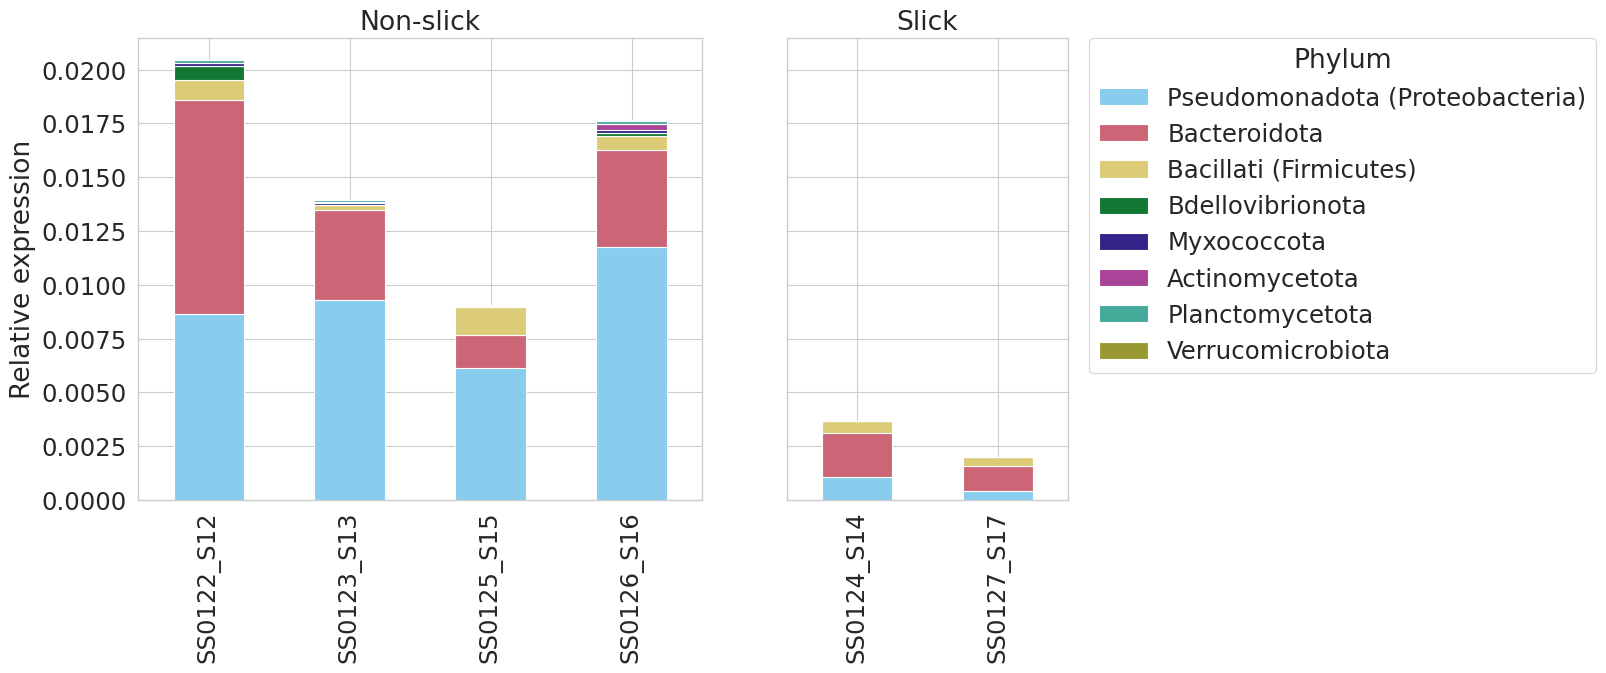

In [14]:
#Plot heterotroph community expression
heterotroph_tpm = phyla_rel_tpm.iloc[2:]
nonslick = heterotroph_tpm[['SS0122_S12','SS0123_S13','SS0125_S15','SS0126_S16']].T
slick = heterotroph_tpm[['SS0124_S14','SS0127_S17']].T
from pypalettes import load_cmap
cmap = load_cmap("Safe").hex
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharey=True,figsize=(12, 6),width_ratios=[4,2])
nonslick.plot.bar(stacked=True, ax=ax0,legend=False,color=cmap)
ax0.set_title('Non-slick')
ax0.set(xlabel=None, ylabel='Relative expression')
slick.plot.bar(stacked=True, ax=ax1,legend=False,color=cmap)
ax1.set_title('Slick')
ax1.set(xlabel=None)
color,label=ax0.get_legend_handles_labels()
fig.legend([ax0, ax1], labels=label,loc="upper right",bbox_to_anchor=(1.35,.9),title='Phylum')
#plt.savefig('output_figures/supp_fig_heterotroph_community_exp.svg',transparent=True,bbox_inches='tight')

/var/tmp/ipykernel_71632/1897823469.py:21: MatplotlibDeprecationWarning: You have mixed positional and keyword arguments, some input may be discarded.  This is deprecated since 3.9 and will become an error in 3.11.
  fig.legend([ax0, ax1], labels=label,


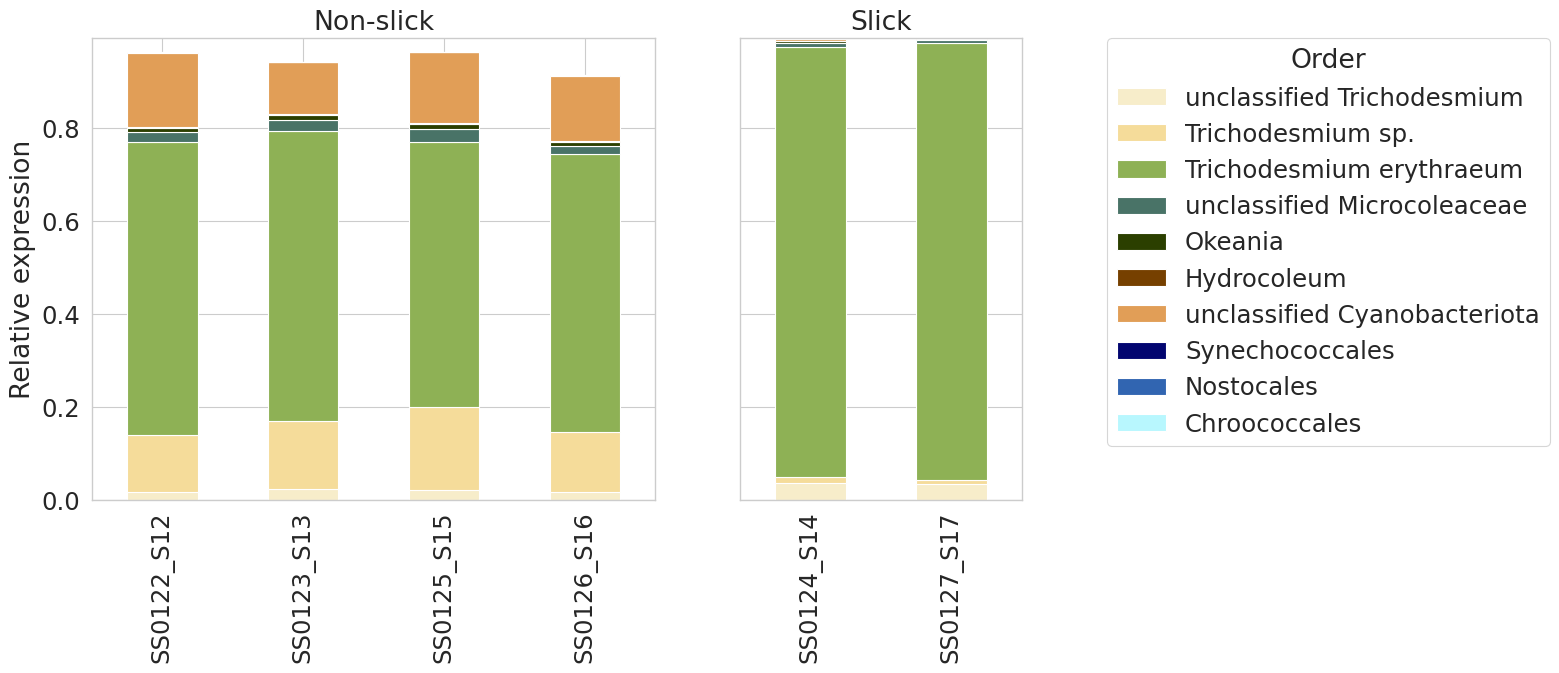

In [15]:
#Plot cyanobacterial community expression

order_tpm = tax_tpm[tax_tpm['phylum'] == 'Cyanobacteriota'].groupby('order')[['SS0127_S17','SS0126_S16', 'SS0124_S14', 'SS0125_S15', 'SS0123_S13', 'SS0122_S12']].sum().drop(['Oscillatoriales'])
#Remove filamentous cyano order and replace with fine-grained info
fil = tax_tpm[tax_tpm['order'] == 'Oscillatoriales'].groupby('genus')[['SS0127_S17','SS0126_S16', 'SS0124_S14', 'SS0125_S15', 'SS0123_S13', 'SS0122_S12']].sum().drop(['Trichodesmium'])
tricho = tax_tpm[tax_tpm['genus'] == 'Trichodesmium'].groupby('species')[['SS0127_S17','SS0126_S16', 'SS0124_S14', 'SS0125_S15', 'SS0123_S13', 'SS0122_S12']].sum()
order_adj = pd.concat([order_tpm,fil,tricho])
order_rel = order_adj/tax_tpm[['SS0127_S17','SS0126_S16', 'SS0124_S14', 'SS0125_S15', 'SS0123_S13', 'SS0122_S12']].sum()
nonslick = order_rel.iloc[::-1][['SS0122_S12','SS0123_S13','SS0125_S15','SS0126_S16']].T
slick = order_rel.iloc[::-1][['SS0124_S14','SS0127_S17']].T

cmap = load_cmap("okavango").hex
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharey=True,figsize=(12, 6),width_ratios=[4,2])
nonslick.plot.bar(stacked=True, ax=ax0,legend=False,color=cmap)
ax0.set_title('Non-slick')
ax0.set(xlabel=None, ylabel='Relative expression')
slick.plot.bar(stacked=True, ax=ax1,legend=False,color=cmap)
ax1.set_title('Slick')
ax1.set(xlabel=None)
color,label=ax0.get_legend_handles_labels()
fig.legend([ax0, ax1], labels=label,
           loc="upper right",bbox_to_anchor=(1.35,.9),title='Order')
#plt.savefig('output_figures/supp_fig_cyano_community_exp.svg',transparent=True,bbox_inches='tight')
#order_rel.to_csv('metaT_files/cyanobacterial_order_relative_expression.csv')

## Differential expression of T. erythraeum genes between colonies and slick

In [22]:
#Get gene coordinates for assembly - need for samtools bedcov
gene_cat = []
with open("metaT_files/hybrid_assembly_prots.bed", "w") as outfile:
    for record in SeqIO.parse("/ocean/projects/ees240006p/agomez3/tricho_virus/tricho_slick_assembly/hybrid_slick_assembly.faa", "fasta"):
        header = record.description
        parts = header.split()
        contig = parts[0].rsplit('_',maxsplit=1)[0]
        gene_id = parts[0].rsplit('_',maxsplit=1)[1]
        start = int(parts[2])
        end = int(parts[4])
        strand = parts[6]
        outfile.write(f"{contig}\t{start}\t{end}\n")
        temp_series = pd.Series(index=['gene','contig','start','end','gene_id','strand'],dtype=object)
        temp_series.loc['gene'] = parts[0]
        temp_series.loc['contig'] = contig
        temp_series.loc['gene_id']  = gene_id
        temp_series.loc['start'] = start
        temp_series.loc['end'] = end
        temp_series.loc['strand'] = strand
        gene_cat.append(temp_series)
gene_info = pd.concat(gene_cat,axis=1).T

/var/tmp/ipykernel_71632/1924622847.py:4: ResourceWarning: unclosed file <_io.TextIOWrapper name='/ocean/projects/ees240006p/agomez3/tricho_virus/tricho_slick_assembly/hybrid_slick_assembly.faa' mode='rt' encoding='UTF-8'>
  for record in SeqIO.parse("/ocean/projects/ees240006p/agomez3/tricho_virus/tricho_slick_assembly/hybrid_slick_assembly.faa", "fasta"):


In [19]:
#Get all contigs whose LCA is T. erythraeum
t_ery = gtdb_tax[gtdb_tax['LCA'] == 'Trichodesmium erythraeum']['contig'].values

In [23]:
to_cat_tpm = []
to_cat_counts = []
for file in glob.glob('metaT_files/*_hybrid_assembly_cds_cov.tab'):
    sample_id = file.rsplit('/',maxsplit=1)[1].split('_')[0]+'_'+file.rsplit('/',maxsplit=1)[1].split('_')[1]
    infile = pd.read_csv(file,sep='\t',header=None,names=['contig','start','end','depth','reads'])
    merged = pd.merge(gene_info,infile,on=['contig','start','end'],how='inner')
    merged = merged[merged['contig'].isin(t_ery)]
    merged.loc[:,'length'] = merged['end'].astype(int) - merged['start']
    merged.loc[:,'rpk'] = merged['reads']/(merged['length']/1000)
    t_ery_scale = infile[infile['contig'].isin(t_ery)]
    pm_scale = (t_ery_scale['reads']/(t_ery_scale['end']/1000)).sum()/1000000
    merged.loc[:,'tpm'] = (merged['rpk']/pm_scale)
    merged = merged.set_index('gene')
    tpms = merged['tpm']
    tpms.name = sample_id
    counts = merged['reads']
    counts.name = sample_id
    to_cat_tpm.append(tpms)
    to_cat_counts.append(counts)

tery_tpm = pd.concat(to_cat_tpm,axis=1).reset_index()
tery_tpm.loc[:,'contig'] = tery_tpm['gene'].str.rsplit('_',n=1,expand=True)[0]
tery_tpm = tery_tpm[tery_tpm['contig'].isin(t_ery)].drop(['contig'],axis=1).set_index('gene')
tery_tpm =  tery_tpm[tery_tpm.sum(axis=1) > 0]
tery_counts = pd.concat(to_cat_counts,axis=1).reset_index()
tery_counts.loc[:,'contig'] = tery_counts['gene'].str.rsplit('_',n=1,expand=True)[0]
tery_counts = tery_counts[tery_counts['contig'].isin(t_ery)].drop(['contig'],axis=1).set_index('gene')
tery_counts =  tery_counts[tery_counts.sum(axis=1) > 0]


In [29]:
#tery_counts.to_csv('metaT_files/tery_raw_gene_counts.csv')
#tery_tpm.to_csv('metaT_files/tery_tpm.csv')

### tery_raw_gene_counts.csv used as input for deseq.R

In [30]:
#read in deseq2 results
deseqRes = pd.read_csv('metaT_files/t_e_deseq_resdf.csv',index_col=0)
deseqRes['significant'] = deseqRes['significant'].fillna('Non-significant')
deseqRes.loc[:,'-log10p'] = -1*np.log10(deseqRes['padj'])
deseqRes.loc[:,'log2mean'] = np.log2(deseqRes['baseMean'])

In [31]:
#read in functional annotations
#Kofam annotations of assembly:
kofam = pd.read_csv('/ocean/projects/ees230009p/shared/slick_bins/kofam_long_read_assembly.txt',sep='\t',skiprows=[0,1],usecols=[1,2,3,4,5,6],names=['gene name',	'KO',	'thrshld',	'score',	'E-value',	'KO definition'],index_col=None)
#Get best hits only
kofam = kofam.sort_values(by='E-value',ascending=True).drop_duplicates(keep='first',subset='gene name')
kofam = kofam[kofam['E-value'] < 10e-10]
kofam.loc[:,'contig'] = kofam['gene name'].str.rsplit('_',n=1,expand=True)[0]
#emapper annotations of assembly
emapper = pd.read_csv('/ocean/projects/ees240006p/agomez3/tricho_virus/tricho_slick_assembly/eggnog_out/emapper_annotations.emapper.annotations',sep='\t',skiprows=[0, 1,2,3])
emapper_tery = emapper[emapper['#query'].isin(tery_tpm.index.values)]
#Uniprot annotations of assembly
uniprot = pd.read_csv('/ocean/projects/ees240006p/agomez3/tricho_virus/tricho_slick_assembly/t_e_slick_prots_uniref.out',sep='\t',header=None,names=['qseqid','qlen','qstart','qend','sseqid','slen','sstart','send','length','pident','positive','evalue'])
uniprot = uniprot.sort_values(by='evalue',ascending=True).drop_duplicates(subset='qseqid',keep='first')
blast_nr = pd.read_csv('/ocean/projects/ees240006p/agomez3/tricho_virus/tricho_slick_assembly/t_e_slick_prots_nr.out',sep='\t',header=None,names=['qseqid','qlen','qstart','qend','sseqid','slen','sstart','send','length','pident','positive','evalue'])

In [32]:
tery_annot_kofam = kofam[kofam['gene name'].isin(deseqRes.index.values)].set_index('gene name')
tery_annot = emapper_tery[emapper_tery['#query'].isin(deseqRes.index.values)].set_index('#query')
tery_annot_uniprot = uniprot[uniprot['qseqid'].isin(deseqRes.index.values)].set_index('qseqid')
de_tery = pd.concat([tery_annot_uniprot,tery_annot_kofam,deseqRes,tery_annot],axis=1)

In [33]:
write = de_tery[['baseMean', 'log2FoldChange','padj','seed_ortholog', 'evalue', 'score', 'eggNOG_OGs', 'max_annot_lvl',
       'COG_category', 'Description', 'Preferred_name', 'GOs', 'EC', 'KEGG_ko','KO definition',
       'KEGG_Pathway','significant']]
#write[(write['significant'] == 'Significant') & (~write['COG_category'].isna())].sort_values(by='log2FoldChange').to_csv('metaT_files/all_sig_tery.csv')

In [38]:
tery_tpm.loc['NODE_125_length_28767_cov_398.849854_8']

SS0124_S14    185.058302
SS0126_S16           0.0
SS0122_S12           0.0
SS0127_S17     74.726447
SS0123_S13           0.0
SS0125_S15           0.0
Name: NODE_125_length_28767_cov_398.849854_8, dtype: object

In [81]:
deseqRes_annot = pd.merge(left=deseqRes,right=tery_annot,left_index=True,right_index=True,how='left')
deseqRes_annot.loc[:,'COG_category'] = deseqRes_annot['COG_category'].str[0].fillna('-')
deseqRes_annot = deseqRes_annot[deseqRes_annot['log2mean'] > 0.1]
#remove outlier
deseqRes_annot = deseqRes_annot[deseqRes_annot['log2FoldChange'] > -25]

In [82]:
cmap = load_cmap("golduck")
cmap1 = load_cmap("golduck").hex
cmap = load_cmap("spinarak")
cmap2 = cmap.hex

In [83]:
COG_function_dict = {'J':'Translation, ribosomal structure and biogenesis', 'A': 'RNA processing and modification', 'K': 'Transcription','L':'Replication, recombination and repair','B': 'Chromatin structure and dynamics',
                     'D': 'Cell cycle control, cell division, chromosome partitioning','V':'Defense mechanisms','T':'Signal transduction','M':'Cell wall/membrane/envelope biogenesis','N': 'Motility', 'U': 'Intracellular trafficking, secretion, and vesicular transport','O':'Posttranslational modification, protein turnover, chaperones',
                     'C': 'Energy production and conversion','G': 'Carbohydrate transport and metabolism', 'E':'Amino acid transport and metabolism','F':'Nucleotide transport and metabolism','H':'Coenzyme transport and metabolism', 'I':'Lipid transport and metabolism','P':'Inorganic ion transport and metabolism','Q':'Secondary metabolites biosynthesis, transport and catabolism',
                     'S':'Uncategorized','-':'Uncategorized'}
COG_color_dict = {'J':cmap1[0], 'A': 'grey', 'K': cmap1[2],'L':cmap1[3],'B': 'grey',
                     'D': cmap2[0],'T':cmap2[2],'M':cmap2[4],'N': cmap2[5], 'U': cmap1[5],'O':cmap2[6],
                      'V':'#11C2B5FF',
                     'C': cmap1[9],'G': cmap1[11], 'E':cmap1[12],'F':cmap2[9],'H':cmap2[12], 'I':cmap2[13],'P':'#A82838FF','Q':'#782028FF',
                     'S':'grey','-':'grey'}
COG_label_dict = {'J':'Information storage & processing', 'A': 'Information storage & processing', 'K': 'Information storage & processing','L':'Information storage & processing','B': 'Information storage & processing',
                     'D': 'Cellular processes & signaling','V':'Defense mechanisms','T':'Cellular processes & signaling','M':'Cellular processes & signaling','N': 'Cellular processes & signaling', 'U': 'Cellular processes & signaling','O':'Cellular processes & signaling',
                     'C': 'Metabolism','G': 'Metabolism', 'E':'Metabolism','F':'Metabolism','H':'Metabolism', 'I':'Metabolism','P':'Metabolism','Q':'Metabolism',
                     'S':'Uncategorized','-':'Uncategorized'}

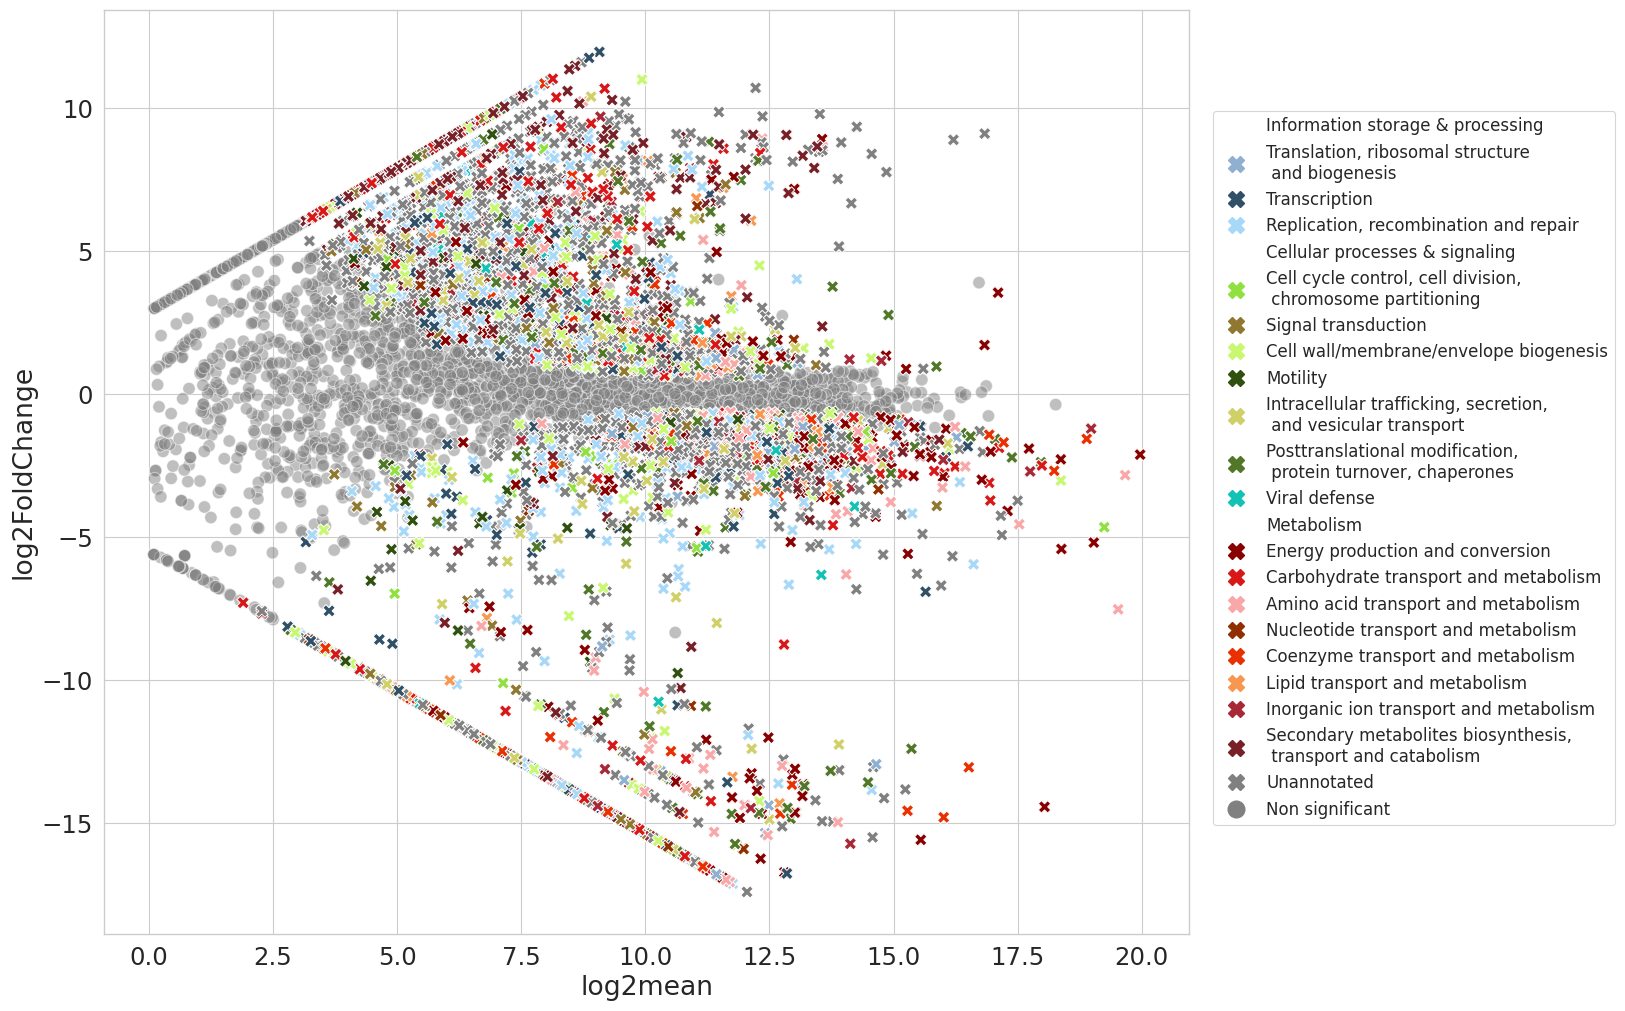

In [84]:
fig,axs = plt.subplots(figsize=(14,12))
g = sns.scatterplot(data = deseqRes_annot, x = 'log2mean',y='log2FoldChange',style='significant',color='grey',alpha=0.5,legend=False,s=80)
g = sns.scatterplot(data = deseqRes_annot[deseqRes_annot['significant'] == 'Significant'], x = 'log2mean',y='log2FoldChange',marker='X',s=80,hue='COG_category',palette=COG_color_dict,legend=False)
info = mlines.Line2D([], [], marker='None', linestyle='None',label='Information storage & processing')
set1 = mlines.Line2D([], [], color=cmap1[0], marker='X', linestyle='None',markersize=12, label='Translation, ribosomal structure \n and biogenesis')
set2 = mlines.Line2D([], [], color=cmap1[2], marker='X', linestyle='None', markersize=12, label='Transcription')
set3 = mlines.Line2D([], [], color=cmap1[3], marker='X', linestyle='None',markersize=12, label='Replication, recombination and repair')
process = mlines.Line2D([], [], marker='None', linestyle='None',label='Cellular processes & signaling')
p1 = mlines.Line2D([], [], color=cmap2[0], marker='X', linestyle='None',markersize=12, label='Cell cycle control, cell division, \n chromosome partitioning')
p2 = mlines.Line2D([], [], color=cmap2[2], marker='X', linestyle='None', markersize=12, label='Signal transduction')
p3 = mlines.Line2D([], [], color=cmap2[4], marker='X', linestyle='None',markersize=12, label='Cell wall/membrane/envelope biogenesis')
p4 = mlines.Line2D([], [], color=cmap2[5], marker='X', linestyle='None',markersize=12, label='Motility')
p5 = mlines.Line2D([], [], color=cmap1[5], marker='X', linestyle='None',markersize=12, label='Intracellular trafficking, secretion, \n and vesicular transport')
p6 = mlines.Line2D([], [], color=cmap2[6], marker='X', linestyle='None',markersize=12, label='Posttranslational modification, \n protein turnover, chaperones')
met = mlines.Line2D([], [], marker='None', linestyle='None',label='Metabolism')
m1 = mlines.Line2D([], [], color=cmap1[9], marker='X', linestyle='None', markersize=12, label='Energy production and conversion')
m2 = mlines.Line2D([], [], color=cmap1[11], marker='X', linestyle='None', markersize=12, label='Carbohydrate transport and metabolism')
m3 = mlines.Line2D([], [], color=cmap1[12], marker='X', linestyle='None', markersize=12, label='Amino acid transport and metabolism')
m4 = mlines.Line2D([], [], color=cmap2[9], marker='X', linestyle='None', markersize=12, label='Nucleotide transport and metabolism')
m5 = mlines.Line2D([], [], color=cmap2[12], marker='X', linestyle='None', markersize=12, label='Coenzyme transport and metabolism')
m6 = mlines.Line2D([], [], color=cmap2[13], marker='X', linestyle='None', markersize=12, label='Lipid transport and metabolism')
m7 = mlines.Line2D([], [], color='#A82838FF', marker='X', linestyle='None', markersize=12, label='Inorganic ion transport and metabolism')
m8 = mlines.Line2D([], [], color='#782028FF', marker='X', linestyle='None', markersize=12, label='Secondary metabolites biosynthesis, \n transport and catabolism')
defense = mlines.Line2D([], [], color='#11C2B5FF', marker='X', linestyle='None', markersize=12, label='Viral defense')
undef = mlines.Line2D([], [], color='grey', marker='X', linestyle='None', markersize=12, label='Unannotated')
nonsig = mlines.Line2D([], [], color='grey', marker='o', linestyle='None', markersize=12, label='Non significant')
plt.legend(handles=[info,set1,set2,set3,process,p1,p2,p3,p4,p5,p6,defense,met,m1,m2,m3,m4,m5,m6,m7,m8,undef,nonsig],bbox_to_anchor=(1.4,.9),loc='upper right', fontsize=12)
#plt.savefig('output_figures/supp_fig_tery_metaT.png',bbox_inches='tight')

## Differential expression of specific functions in T. erythraeum

In [54]:
#Known KOs of Fe, P, and nucleotide stress response
pstress_ko = ['K06163','K07093','K07093','K02040','K01406','K01406','K01126','K06118']
nucl_met_ko = ['K13483','K01485','K09903','K00764','K03787','K01939','K01955','K00945','K13799','K03787','K01465','K01465','K03787','K02428','K00948','K01591','K00759','K01524']
fe_stress_ko = ['K09772','K03798','K03531','K03798','K03798','K03711','K03798','K02638','K08906','K03711','K01623','K02313','K03839','K00485','K02012','K04758','K04759','K03839','K02650','K02705','K21480','K04047','K03594']
p_stress_genes = list(tery_annot_kofam[tery_annot_kofam['KO'].isin(pstress_ko)].index.values)
nucl_met_genes = list(tery_annot_kofam[tery_annot_kofam['KO'].isin(nucl_met_ko)].index.values)
fe_stress_genes = list(tery_annot_kofam[tery_annot_kofam['KO'].isin(fe_stress_ko)].index.values)

In [55]:
#genes encoding gas vesicle proteins
gv = list(de_tery[(de_tery['KO definition'].str.contains('gas vesicle',na=False)) | (de_tery['Description'].str.contains('gas vesicle',na=False))].sort_values(by='E-value').index.values)

In [58]:
gene_list = {'P stress': p_stress_genes, 'Nucleotide metabolism': nucl_met_genes,'Fe stress':fe_stress_genes,'Gas vesicles':gv}
to_cat = []
to_cat_df = []
for group in gene_list.keys():
    genes = gene_list[group]
    write_subset = write.loc[genes]
    write_subset.loc[:,'Stress Category'] = group
    to_cat_df.append(write_subset)
    tpm_stacked = tery_tpm.loc[genes].stack().reset_index()
    tpm_stacked.columns = ['cds_id','sample','tpm']
    tpm_stacked['tpm'] = tpm_stacked['tpm'].astype('float')
    tpm_stacked.loc[:,'log_tpm'] = np.log10(tpm_stacked['tpm'])
    tpm_stacked.loc[:,'source'] = tpm_stacked['sample'].map(sample_dict)
    tpm_stacked.loc[:,'category'] = group
    to_cat.append(tpm_stacked)
all_groups = pd.concat(to_cat)
all_groups = all_groups.reset_index()

/jet/home/agomez3/.local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/jet/home/agomez3/.local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/jet/home/agomez3/.local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [60]:
#pd.concat(to_cat_df).to_csv('output_tables/supp_table_fig2b.csv')

In [62]:
#tery_tpm.loc[pd.concat(to_cat_df).index.values].to_csv('output_tables/supp_table_fig2b_tpm.csv')

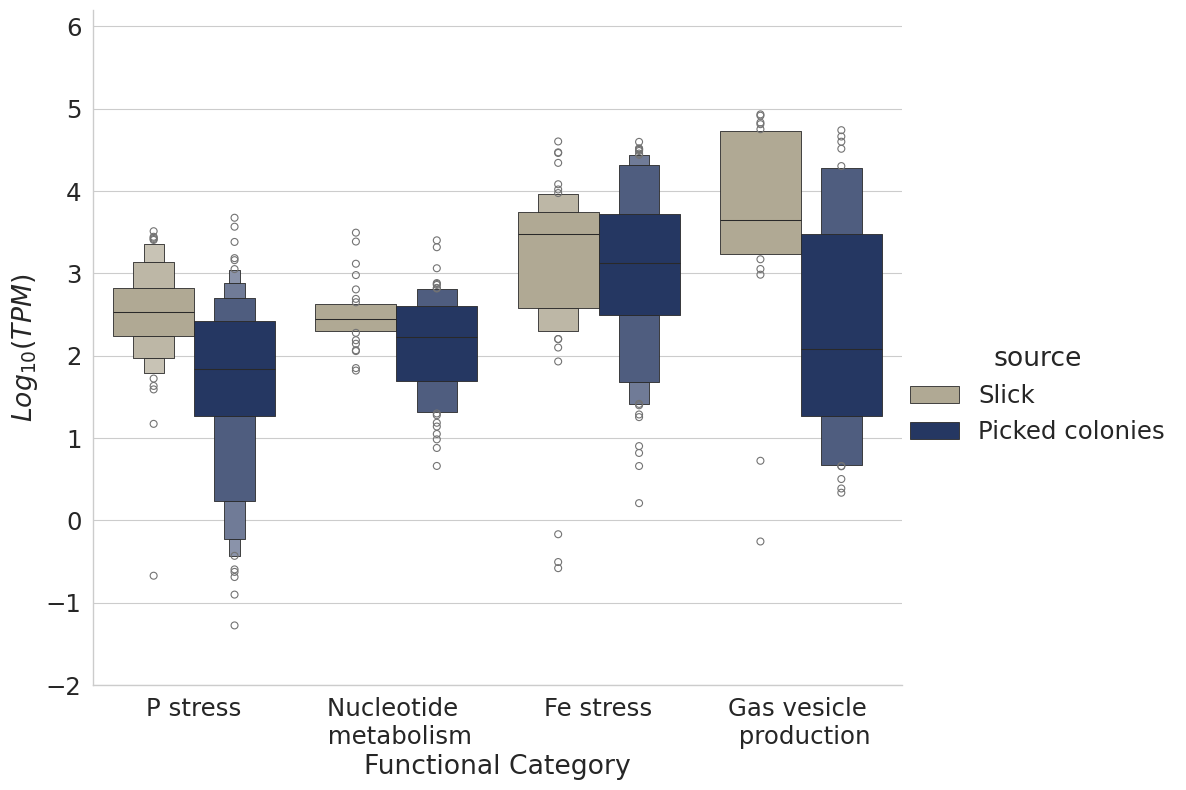

In [88]:
g = sns.catplot(data=all_groups, hue='source', y='log_tpm',x='category', palette = ['#B5AB8F','#1B336C'],kind='boxen',height=8, aspect=1.2)
g.set_axis_labels('Functional Category','$Log_{10}(TPM)$')
g.set_xticklabels(["P stress", "Nucleotide \n metabolism", "Fe stress", 'Gas vesicle \n production'])
g.set(ylim=(-2, 6.2))
#plt.savefig('output_figures/fig2b_tery_stress_comp.svg',transparent=True,bbox_inches='tight')

In [91]:
#KS test between Picked colonies and slick for 4 functional categories
for group in all_groups['category'].unique():
    non_slick = all_groups[(all_groups['source'] == 'Picked colonies') & (all_groups['category'] == group)]['tpm']
    slick = all_groups[(all_groups['source'] == 'Slick') & (all_groups['category'] == group)]['tpm']
    print(group,stats.kstest(slick,non_slick))

P stress KstestResult(statistic=0.4418604651162791, pvalue=1.6690070431397923e-10, statistic_location=105.15174373373664, statistic_sign=-1)
Nucleotide metabolism KstestResult(statistic=0.3333333333333333, pvalue=0.02110217477875078, statistic_location=90.64347873264911, statistic_sign=-1)
Fe stress KstestResult(statistic=0.13333333333333333, pvalue=0.46455199338580366, statistic_location=0.6791451379857291, statistic_sign=1)
Gas vesicles KstestResult(statistic=0.4722222222222222, pvalue=0.007653810932745209, statistic_location=822.7579204618297, statistic_sign=-1)
